# AAA 2024/2025 - Project 1
## Group 8: António Estêvão (58203), Diogo Venes (58216)

## 1. Exploratory data analysis

In [1]:
import pandas as pd
#from ydata_profiling import ProfileReport

df = pd.read_csv('cardiovascular_train.csv')
df_test = pd.read_csv('cardiovascular_test.csv')
#profile = ProfileReport(df, title='Cardiovascular Data Report', explorative=True)
#profile.to_file("cardiovascular_data_report.html")

Based on the data report we can see that we have some features which are highly imbalanced, such as Anxiety, Depression, Diabetes and SleepDuration. This is to be expected in regard to the features that are medical conditions, as the vast majority of people do not have these conditions. The SleepDuration feature is imbalanced due to the way the classes were set up, putting most people in the 6-9 hour class.  We will deal with one of these imbalances later on. On the other hand, we also have to keep in mind for future analysis that the provided dataset is comparatively small, and as such we need to be careful as the conclusions drawn might not be representative of the underlying distribution.
Below we can find a graphical representation of the most imbalanced features.

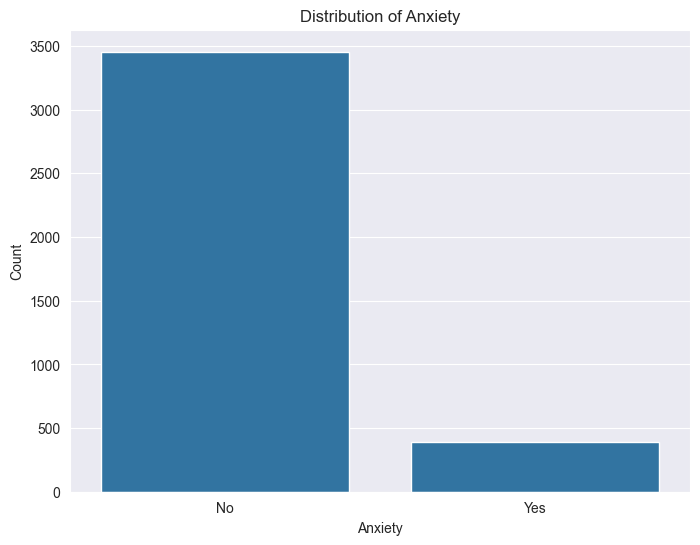

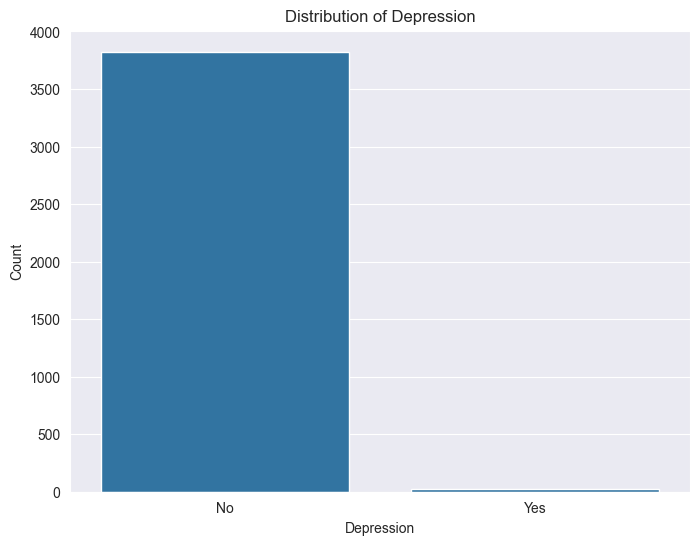

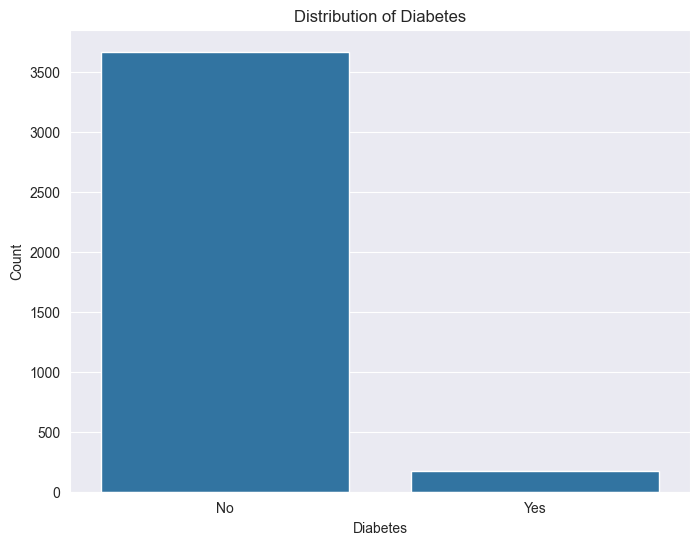

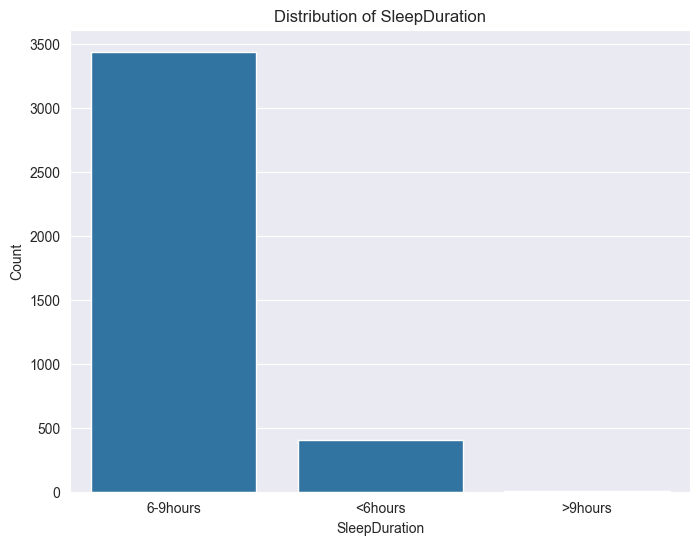

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

variables = ['Anxiety', 'Depression', 'Diabetes', 'SleepDuration']

for var in variables:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x=var)
    plt.title(f'Distribution of {var}')
    plt.ylabel('Count')
    plt.xlabel(var)
    plt.show()

## 2. Learning a bayesian network from the data

In [ ]:
from pgmpy.base import DAG

# Function taken from the TP7 notebook
def initialize_graph(nodes,p=1):
  G = DAG()
  G.add_nodes_from(nodes=nodes)
  init = G.get_random(n_nodes=len(nodes), edge_prob=p)
  ls = []
  mapping = {}
  for k in range(len(nodes)):
      mapping[k] = nodes[k]
  for i,j in init.edges:
    ls.append((mapping[i],mapping[j]))
  ls
  G.add_edges_from(ebunch=ls) # G is the required initialization for the Hill Climbing method
  return G

Here, we decide to define ways of imbuing some domain knowledge into our model. To achieve this, we define some known links that we know should be present in our final network. Conversely, we also define some unwanted links that we know make no sense in our network, mainly links that imply that various factors can influence Age and Sex, which we assume to be predefined and unchangeable. However, we want to make sure we don't imbue our model with too much domain knowledge (as is commented), as at that point we would almost be making the network ourselves with the ideas we think to be true. The point of this is mainly to see what the data, even if limited, can tell us and what network arises from it, even if, for example, we see some edges that don't make sense to us in the learned network.

In [ ]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore, K2Score, BDeuScore, BayesianEstimator, MaximumLikelihoodEstimator

known_links = [('PhysicalActivity', 'Hypertension'), ('PhysicalActivity', 'Hypercholesterolemia'), ('Age', 'BodyMassIndex')]
# known_links = [
#       ('PhysicalActivity', 'Hypertension'),
#       ('PhysicalActivity', 'Hypercholesterolemia'),
#       ('Age', 'BodyMassIndex'),
#       ('SmokerProfile', 'Hypertension'),
#       ('SmokerProfile', 'Hypercholesterolemia'),
# ]

unwanted_links = [('Age', 'Sex'), ('Anxiety', 'Sex'), ('PhysicalActivity', 'Sex'), ('SleepDuration', 'Age'), ('SmokerProfile', 'Age')]
#unwanted_links = [('Age', 'Sex'), ('Sex', 'Age'), ('Anxiety', 'Sex'), ('PhysicalActivity', 'Sex'), ('SleepDuration', 'Age'), ('SmokerProfile', 'Age'), ('Hypercholesterolemia', 'Sex')]

hc = HillClimbSearch(data=df)

scoring_methods = {
    'K2': K2Score(df),
    'BDeu': BDeuScore(df, equivalent_sample_size=10),
    #'BIC': BicScore(df)
}

In [17]:
results = {}

for name, scoring_method in scoring_methods.items():
    best_model = hc.estimate(scoring_method=scoring_method, fixed_edges=known_links, black_list=unwanted_links)
    results[name] = {
        'edges': best_model.edges(),
        'score': scoring_method.score(best_model)
    }

for name, result in results.items():
    print(f"Scoring Method: {name}")
    print(f"Edges: {result['edges']}")
    print(f"Num edges: {len(result['edges'])}")
    print(f"Score: {result['score']}\n")

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Scoring Method: K2
Edges: [('Age', 'BodyMassIndex'), ('Age', 'SmokerProfile'), ('Age', 'PhysicalActivity'), ('Age', 'Hypercholesterolemia'), ('Age', 'SocioeconomicStatus'), ('Anxiety', 'BodyMassIndex'), ('Anxiety', 'SmokerProfile'), ('Anxiety', 'SocioeconomicStatus'), ('Depression', 'BodyMassIndex'), ('Depression', 'SmokerProfile'), ('Depression', 'SocioeconomicStatus'), ('Diabetes', 'BodyMassIndex'), ('Diabetes', 'PhysicalActivity'), ('Diabetes', 'SmokerProfile'), ('Diabetes', 'Hypercholesterolemia'), ('Diabetes', 'SocioeconomicStatus'), ('Diabetes', 'Hypertension'), ('EducationLevel', 'BodyMassIndex'), ('EducationLevel', 'SmokerProfile'), ('EducationLevel', 'SocioeconomicStatus'), ('Hypercholesterolemia', 'BodyMassIndex'), ('Hypercholesterolemia', 'SmokerProfile'), ('Hypercholesterolemia', 'Hypertension'), ('Hypercholesterolemia', 'SocioeconomicStatus'), ('Hypertension', 'BodyMassIndex'), ('Hypertension', 'SmokerProfile'), ('Hypertension', 'SocioeconomicStatus'), ('Hypertension', 'An

Looking at the output of the above cell, we can see that the different scoring methods give us wildly different models, whether it be in terms of edges or score. However, looking at the K2 scored network, we can see that there are 47 edges, which we consider to be too many and likely overfitting. The BDeu scored network has fewer edges, and despite a worse score at face value, it is in fact good as we want to maximize the log likelihood. We will use the BDeu scored network for the rest of the project.

In [25]:
best_model = hc.estimate(scoring_method=scoring_methods['BDeu'], fixed_edges=known_links, black_list=unwanted_links)
#best_model = hc.estimate(scoring_method=scoring_methods['K2'], start_dag=initialize_graph(nodes=df.columns, p=0.5), black_list=[('Age', 'Sex'), ('Anxiety', 'Sex')])
print("Best model edges:", best_model.edges())
print("Best model score:", scoring_methods['BDeu'].score(best_model))
model = BayesianNetwork(best_model.edges())
model.fit(df, estimator=BayesianEstimator, prior_type='BDeu')

  0%|          | 0/1000000 [00:00<?, ?it/s]

Best model edges: [('Age', 'BodyMassIndex'), ('Age', 'PhysicalActivity'), ('Age', 'SmokerProfile'), ('Age', 'SocioeconomicStatus'), ('Age', 'SleepDuration'), ('Age', 'Hypercholesterolemia'), ('BodyMassIndex', 'Hypertension'), ('BodyMassIndex', 'SocioeconomicStatus'), ('Diabetes', 'PhysicalActivity'), ('Diabetes', 'Hypercholesterolemia'), ('EducationLevel', 'SocioeconomicStatus'), ('EducationLevel', 'Depression'), ('Hypercholesterolemia', 'SleepDuration'), ('Hypercholesterolemia', 'Hypertension'), ('Hypercholesterolemia', 'SmokerProfile'), ('Hypertension', 'Anxiety'), ('PhysicalActivity', 'Hypertension'), ('PhysicalActivity', 'Hypercholesterolemia'), ('PhysicalActivity', 'SmokerProfile'), ('Sex', 'PhysicalActivity'), ('Sex', 'Anxiety'), ('Sex', 'Hypercholesterolemia'), ('SleepDuration', 'EducationLevel'), ('SleepDuration', 'Depression'), ('SmokerProfile', 'BodyMassIndex')]
Best model score: -31558.276548638616


In terms of the estimator, we have, in theory, three options: Maximum Likelihood Estimator (MLE), Bayesian Estimator and Expectation Maximization. As we don't have any latent variables or even any missing data in out dataset, we considered it inappropriate to use the Expectation Maximization estimator. The MLE is known to overfit to the data in small datasets, meaning that if our data is unrepresentative of the underlying distribution, the estimations will be poor. With lack of data being a problem in our case, as the dataset we have isn't the complete one, we therefore decided to use the Bayesian Estimator.

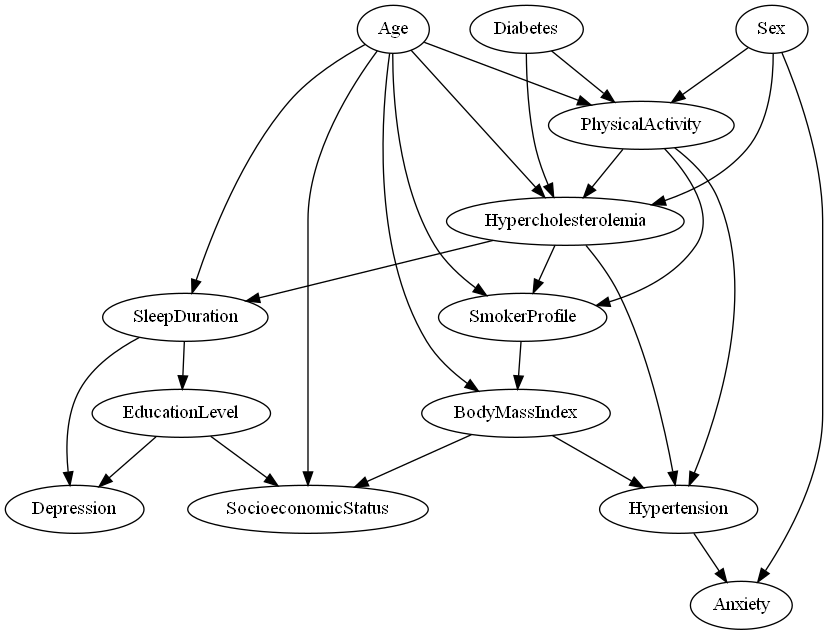

In [27]:
import os
import pathlib
import sys

# Code taken from a GitHub discussion
if sys.platform == 'win32':
    path = pathlib.Path(r'C:\Program Files\Graphviz\bin')
    if path.is_dir() and str(path) not in os.environ['PATH']:
        os.environ['PATH'] += f';{path}'

from IPython.display import Image, display

m = model.to_graphviz()
image = m.draw(format='png', prog='dot')
display(Image(image))

# other_model = hc.estimate(scoring_method=scoring_methods['K2'], fixed_edges=known_links, black_list=unwanted_links)
# model2 = BayesianNetwork(other_model.edges())
# m2 = model2.to_graphviz()
# image2 = m2.draw(format='png', prog='dot')
# display(Image(image2))

## 3. Inference

In [28]:
from pgmpy.inference import VariableElimination
inference = VariableElimination(model)

age1824_effect_on_sleep = inference.query(variables=['SleepDuration'], evidence={'Age': '18-24'})
print("Age 18-24 effect on sleep")
print(age1824_effect_on_sleep)

age2434_effect_on_sleep = inference.query(variables=['SleepDuration'], evidence={'Age': '24-34'})
print("Age 24-34 effect on sleep")
print(age2434_effect_on_sleep)

age3444_effect_on_sleep = inference.query(variables=['SleepDuration'], evidence={'Age': '34-44'})
print("Age 34-44 effect on sleep")
print(age3444_effect_on_sleep)

age4454_effect_on_sleep = inference.query(variables=['SleepDuration'], evidence={'Age': '44-54'})
print("Age 44-54 effect on sleep")
print(age4454_effect_on_sleep)

age5464_effect_on_sleep = inference.query(variables=['SleepDuration'], evidence={'Age': '54-64'})
print("Age 54-64 effect on sleep")
print(age5464_effect_on_sleep)

Age 18-24 effect on sleep
+-------------------------+----------------------+
| SleepDuration           |   phi(SleepDuration) |
+=========================+======================+
| SleepDuration(6-9hours) |               0.9804 |
+-------------------------+----------------------+
| SleepDuration(<6hours)  |               0.0098 |
+-------------------------+----------------------+
| SleepDuration(>9hours)  |               0.0098 |
+-------------------------+----------------------+
Age 24-34 effect on sleep
+-------------------------+----------------------+
| SleepDuration           |   phi(SleepDuration) |
+=========================+======================+
| SleepDuration(6-9hours) |               0.9405 |
+-------------------------+----------------------+
| SleepDuration(<6hours)  |               0.0575 |
+-------------------------+----------------------+
| SleepDuration(>9hours)  |               0.0020 |
+-------------------------+----------------------+
Age 34-44 effect on sleep
+---

Analysing the above results, we can see that the probability of sleeping 6-9 hours is higher for people aged 18-24 and 24-34, and decreases as age increases. This is to be expected, as intuitively younger people tend to sleep more than older people. In the same vein, the probability of sleeping less than 6 hours increases as age increases. Finally, the probability of sleeping more than 9 hours is higher for people aged 18-24 and 24-34, and decreases as age increases, which again matches up with what we would expect.

In [29]:
smoker_effect_on_conditions = inference.query(variables=['Diabetes'], evidence={'SmokerProfile': 'Smoker'})
print("Smoker effect on conditions")
print(smoker_effect_on_conditions)

non_smoker_effect_on_conditions = inference.query(variables=['Diabetes'], evidence={'SmokerProfile': 'Non_Smoker'})
print("Non Smoker effect on conditions")
print(non_smoker_effect_on_conditions)

ex_smoker_effect_on_conditions = inference.query(variables=['Diabetes'], evidence={'SmokerProfile': 'Ex_Smoker'})
print("Ex Smoker effect on conditions")
print(ex_smoker_effect_on_conditions)

Smoker effect on conditions
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9456 |
+---------------+-----------------+
| Diabetes(Yes) |          0.0544 |
+---------------+-----------------+
Non Smoker effect on conditions
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9569 |
+---------------+-----------------+
| Diabetes(Yes) |          0.0431 |
+---------------+-----------------+
Ex Smoker effect on conditions
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9558 |
+---------------+-----------------+
| Diabetes(Yes) |          0.0442 |
+---------------+-----------------+


Looking at the above results, we can see that the probability of having diabetes is higher for smokers than for non-smokers and ex-smokers. This is to be expected, as smoking is known to be a risk factor for diabetes. The probability of having diabetes is higher for ex-smokers than for non-smokers, which is also expected as ex-smokers are more likely to have diabetes than non-smokers. However, the differences are very small, which could be due to the fact that the dataset is not complete and as such the results are not representative of the underlying distribution.

In [30]:
smoker_effect_on_conditions = inference.query(variables=['Hypertension'], evidence={'SmokerProfile': 'Smoker'})
print("Smoker effect on conditions")
print(smoker_effect_on_conditions)

non_smoker_effect_on_conditions = inference.query(variables=['Hypertension'], evidence={'SmokerProfile': 'Non_Smoker'})
print("Non Smoker effect on conditions")
print(non_smoker_effect_on_conditions)

ex_smoker_effect_on_conditions = inference.query(variables=['Hypertension'], evidence={'SmokerProfile': 'Ex_Smoker'})
print("Ex Smoker effect on conditions")
print(ex_smoker_effect_on_conditions)

Smoker effect on conditions
+-------------------+---------------------+
| Hypertension      |   phi(Hypertension) |
+===================+=====================+
| Hypertension(No)  |              0.7902 |
+-------------------+---------------------+
| Hypertension(Yes) |              0.2098 |
+-------------------+---------------------+
Non Smoker effect on conditions
+-------------------+---------------------+
| Hypertension      |   phi(Hypertension) |
+===================+=====================+
| Hypertension(No)  |              0.8147 |
+-------------------+---------------------+
| Hypertension(Yes) |              0.1853 |
+-------------------+---------------------+
Ex Smoker effect on conditions
+-------------------+---------------------+
| Hypertension      |   phi(Hypertension) |
+===================+=====================+
| Hypertension(No)  |              0.8154 |
+-------------------+---------------------+
| Hypertension(Yes) |              0.1846 |
+-------------------+--------

Again analysing the results, we can see that the probability of having hypertension is higher for smokers than for non-smokers and ex-smokers. This makes sense with what we intuitively know. However, we see that ex-smokers have a lower probability of having hypertension than non-smokers, which is not what we would expect. This could, once again, be due to the fact that the dataset is not complete and as such the results are not representative of the underlying distribution.

In [31]:
smoker_effect_on_conditions = inference.query(variables=['Hypercholesterolemia'], evidence={'SmokerProfile': 'Smoker'})
print("Smoker effect on conditions")
print(smoker_effect_on_conditions)

non_smoker_effect_on_conditions = inference.query(variables=['Hypercholesterolemia'], evidence={'SmokerProfile': 'Non_Smoker'})
print("Non Smoker effect on conditions")
print(non_smoker_effect_on_conditions)

ex_smoker_effect_on_conditions = inference.query(variables=['Hypercholesterolemia'], evidence={'SmokerProfile': 'Ex_Smoker'})
print("Ex Smoker effect on conditions")
print(ex_smoker_effect_on_conditions)

Smoker effect on conditions
+---------------------------+-----------------------------+
| Hypercholesterolemia      |   phi(Hypercholesterolemia) |
+===========================+=============================+
| Hypercholesterolemia(No)  |                      0.5542 |
+---------------------------+-----------------------------+
| Hypercholesterolemia(Yes) |                      0.4458 |
+---------------------------+-----------------------------+
Non Smoker effect on conditions
+---------------------------+-----------------------------+
| Hypercholesterolemia      |   phi(Hypercholesterolemia) |
+===========================+=============================+
| Hypercholesterolemia(No)  |                      0.6527 |
+---------------------------+-----------------------------+
| Hypercholesterolemia(Yes) |                      0.3473 |
+---------------------------+-----------------------------+
Ex Smoker effect on conditions
+---------------------------+-----------------------------+
| Hyperch

Once again analysing these results, we can see that the probability of having hypercholesterolemia is considerably higher for both smokers and ex-smokers than it is for non-smokers. In this case, we see more pronounced differences than in previous cases, which lines up more with what we would expect.

In [32]:
obese_effect_on_conditions = inference.query(variables=['Diabetes'], evidence={'BodyMassIndex': 'Obese'})
print("Obese effect on diabetes")
print(obese_effect_on_conditions)

overweight_effect_on_conditions = inference.query(variables=['Diabetes'], evidence={'BodyMassIndex': 'Overweight'})
print("Overweight effect on diabetes")
print(overweight_effect_on_conditions)

normal_effect_on_conditions = inference.query(variables=['Diabetes'], evidence={'BodyMassIndex': 'Normal'})
print("Normal effect on diabetes")
print(normal_effect_on_conditions)

underweight_effect_on_conditions = inference.query(variables=['Diabetes'], evidence={'BodyMassIndex': 'Underweight'})
print("Underweight effect on diabetes")
print(underweight_effect_on_conditions)

Obese effect on diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9554 |
+---------------+-----------------+
| Diabetes(Yes) |          0.0446 |
+---------------+-----------------+
Overweight effect on diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9544 |
+---------------+-----------------+
| Diabetes(Yes) |          0.0456 |
+---------------+-----------------+
Normal effect on diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9525 |
+---------------+-----------------+
| Diabetes(Yes) |          0.0475 |
+---------------+-----------------+
Underweight effect on diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |       

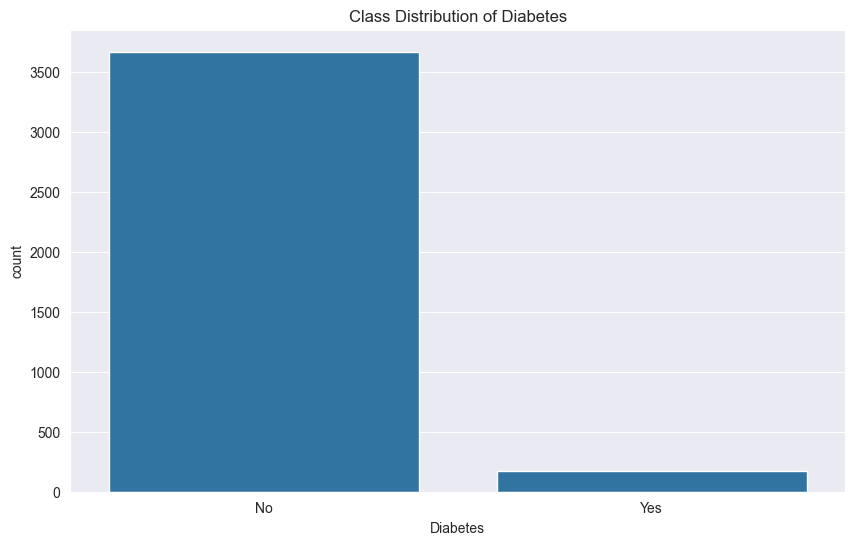

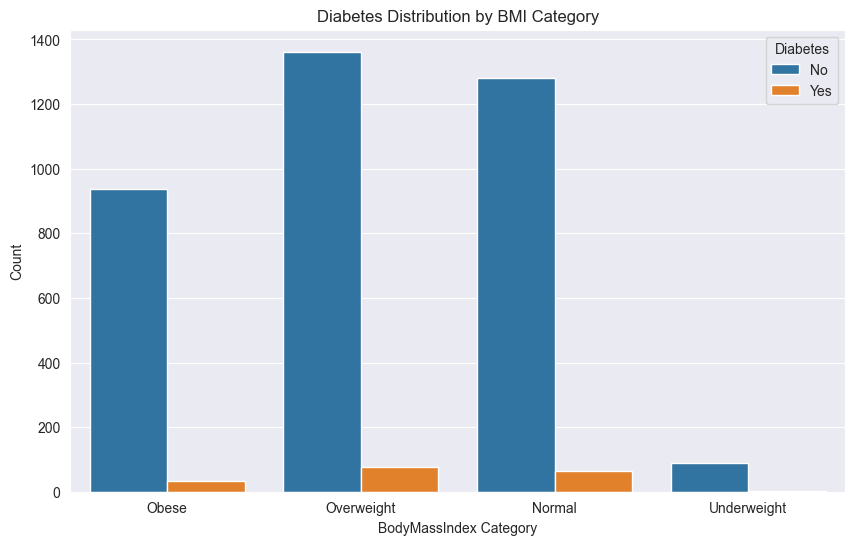

In [33]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Diabetes', data=df)
plt.title('Class Distribution of Diabetes')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='BodyMassIndex', hue='Diabetes', data=df, order=['Obese', 'Overweight', 'Normal', 'Underweight'])
plt.title('Diabetes Distribution by BMI Category')
plt.xlabel('BodyMassIndex Category')
plt.ylabel('Count')
plt.legend(title='Diabetes')
plt.show()

Looking at the above results, we can see that the probabilities don't evolve in a way that we would consider normal. This can be explained due to the fact that the dataset includes very few people with diabetes, and the distribution of diabetics between classes is largely proportional to the distribution of the BMI classes themselves. This is a problem as it makes it difficult to draw any conclusions from the data, as the results are not representative of the underlying distribution.

In [34]:
obese_effect_on_conditions = inference.query(variables=['Hypertension'], evidence={'BodyMassIndex': 'Obese'})
print("Obese effect on hypertension")
print(obese_effect_on_conditions)

overweight_effect_on_conditions = inference.query(variables=['Hypertension'], evidence={'BodyMassIndex': 'Overweight'})
print("Overweight effect on hypertension")
print(overweight_effect_on_conditions)

normal_effect_on_conditions = inference.query(variables=['Hypertension'], evidence={'BodyMassIndex': 'Normal'})
print("Normal effect on hypertension")
print(normal_effect_on_conditions)

underweight_effect_on_conditions = inference.query(variables=['Hypertension'], evidence={'BodyMassIndex': 'Underweight'})
print("Underweight effect on hypertension")
print(underweight_effect_on_conditions)

Obese effect on hypertension
+-------------------+---------------------+
| Hypertension      |   phi(Hypertension) |
+===================+=====================+
| Hypertension(No)  |              0.7772 |
+-------------------+---------------------+
| Hypertension(Yes) |              0.2228 |
+-------------------+---------------------+
Overweight effect on hypertension
+-------------------+---------------------+
| Hypertension      |   phi(Hypertension) |
+===================+=====================+
| Hypertension(No)  |              0.8425 |
+-------------------+---------------------+
| Hypertension(Yes) |              0.1575 |
+-------------------+---------------------+
Normal effect on hypertension
+-------------------+---------------------+
| Hypertension      |   phi(Hypertension) |
+===================+=====================+
| Hypertension(No)  |              0.8009 |
+-------------------+---------------------+
| Hypertension(Yes) |              0.1991 |
+-------------------+------

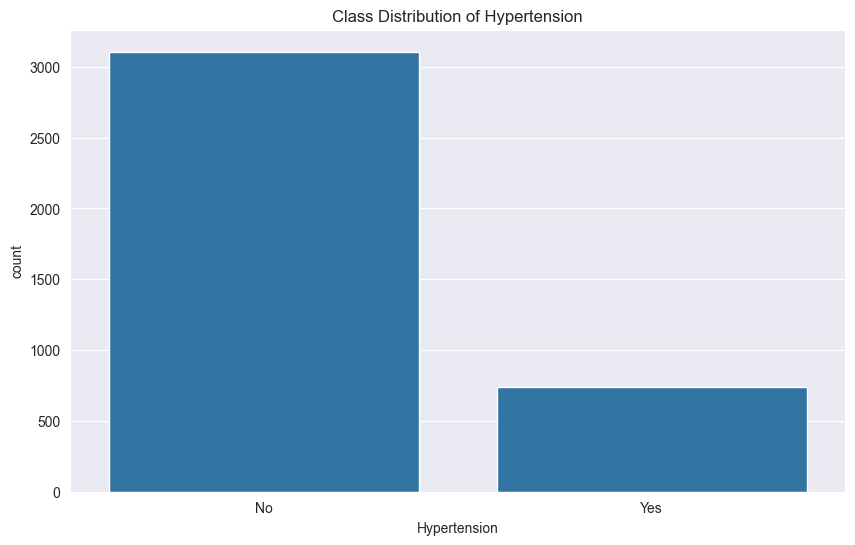

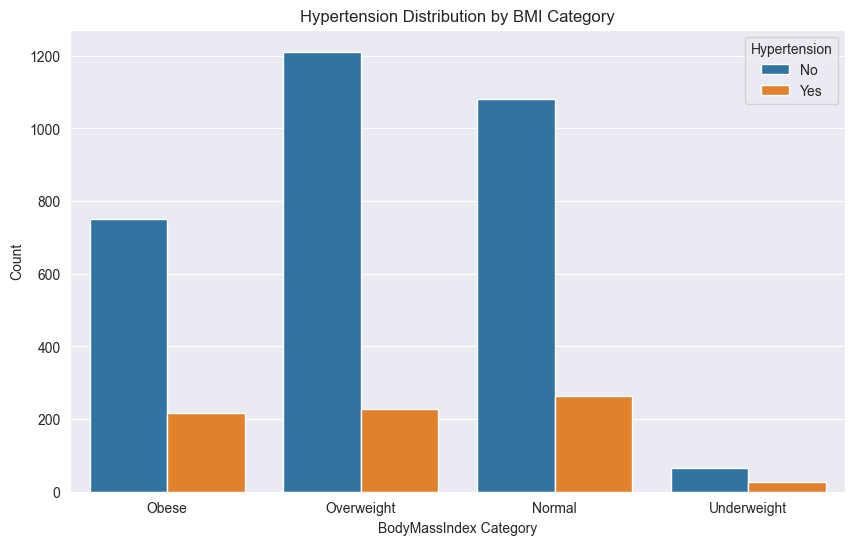

In [35]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Hypertension', data=df)
plt.title('Class Distribution of Hypertension')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='BodyMassIndex', hue='Hypertension', data=df, order=['Obese', 'Overweight', 'Normal', 'Underweight'])
plt.title('Hypertension Distribution by BMI Category')
plt.xlabel('BodyMassIndex Category')
plt.ylabel('Count')
plt.legend(title='Hypertension')
plt.show()

Observing the above results, we can see that Obese samples have a higher probability of having hypertension than Normal samples. However, we then observe that Underweight samples have the highest probability of having Hypertension, and Overweight samples have the lowest probability of having Hypertension. This is not what we would expect, and is likely due to the fact that the dataset is not extensive enough and as such the results are not representative of the underlying distribution. We can see that the number of Overweight samples is larger than both Normal and Obese, however the occurrence of Hypertension samples is actually lower than in the Normal category. On the other hand, despite the considerably lower number of Underweight samples, we have a comparatively large number of Hypertension patients. Our model and its predictions are, after all, entirely reliant on the quantity of data we have and the abilities of our data sample to represent the underlying distribution.

In [36]:
obese_effect_on_conditions = inference.query(variables=['Hypercholesterolemia'], evidence={'BodyMassIndex': 'Obese'})
print("Obese effect on hypercholesterolemia")
print(obese_effect_on_conditions)

overweight_effect_on_conditions = inference.query(variables=['Hypercholesterolemia'], evidence={'BodyMassIndex': 'Overweight'})
print("Overweight effect on hypercholesterolemia")
print(overweight_effect_on_conditions)

normal_effect_on_conditions = inference.query(variables=['Hypercholesterolemia'], evidence={'BodyMassIndex': 'Normal'})
print("Normal effect on hypercholesterolemia")
print(normal_effect_on_conditions)

underweight_effect_on_conditions = inference.query(variables=['Hypercholesterolemia'], evidence={'BodyMassIndex': 'Underweight'})
print("Underweight effect on hypercholesterolemia")
print(underweight_effect_on_conditions)

Obese effect on hypercholesterolemia
+---------------------------+-----------------------------+
| Hypercholesterolemia      |   phi(Hypercholesterolemia) |
+===========================+=============================+
| Hypercholesterolemia(No)  |                      0.6512 |
+---------------------------+-----------------------------+
| Hypercholesterolemia(Yes) |                      0.3488 |
+---------------------------+-----------------------------+
Overweight effect on hypercholesterolemia
+---------------------------+-----------------------------+
| Hypercholesterolemia      |   phi(Hypercholesterolemia) |
+===========================+=============================+
| Hypercholesterolemia(No)  |                      0.6154 |
+---------------------------+-----------------------------+
| Hypercholesterolemia(Yes) |                      0.3846 |
+---------------------------+-----------------------------+
Normal effect on hypercholesterolemia
+---------------------------+--------------

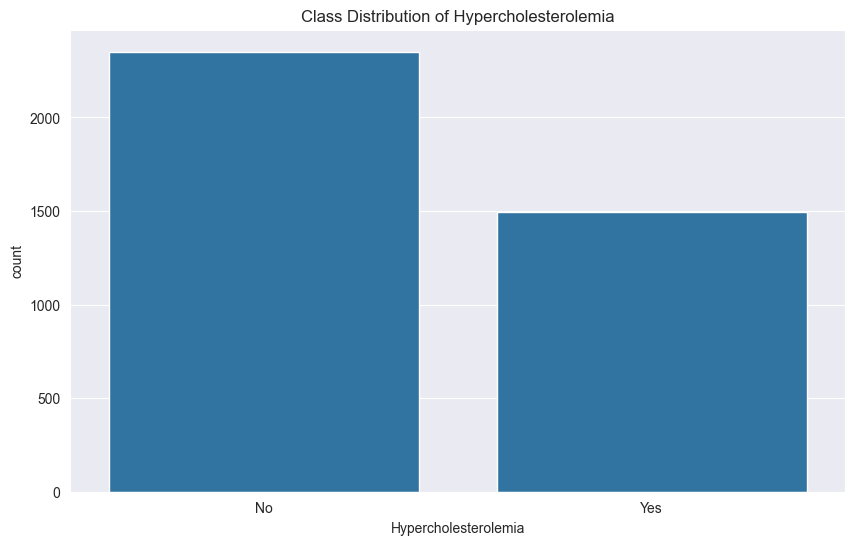

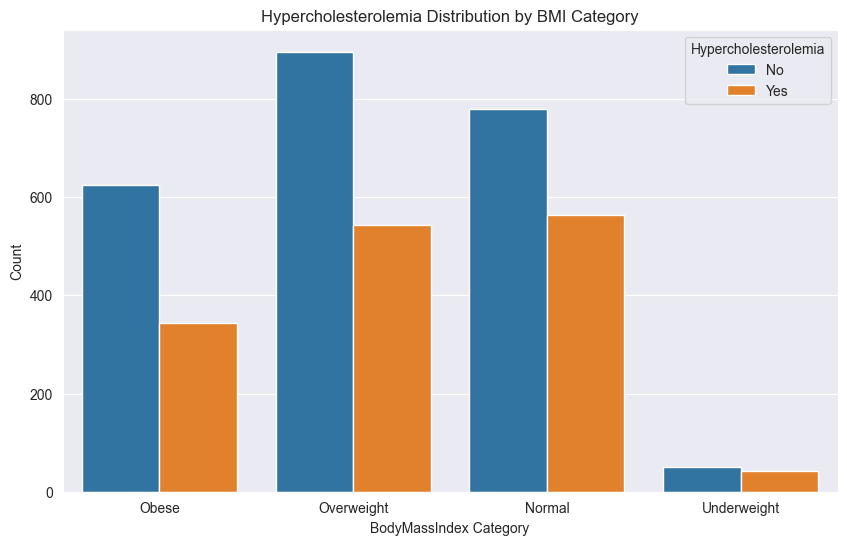

In [37]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Hypercholesterolemia', data=df)
plt.title('Class Distribution of Hypercholesterolemia')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='BodyMassIndex', hue='Hypercholesterolemia', data=df, order=['Obese', 'Overweight', 'Normal', 'Underweight'])
plt.title('Hypercholesterolemia Distribution by BMI Category')
plt.xlabel('BodyMassIndex Category')
plt.ylabel('Count')
plt.legend(title='Hypercholesterolemia')
plt.show()

Analysing the results, we see an even more counterintuitive output in this scenario. Despite there being a good number of Hypercholesterolemia samples in general, its distribution by BMI categories is not how we would expect. We can see that, for example, the Normal category has slightly more sufferers than the Overweight category, despite there being more samples in the Overweight category, which is not what we would expect, as we would naturally associate people in a Normal BMI category to have considerably less probability of having Hypercholesterolemia than people in an Overweight category. This once again highlights the importance of having a representative dataset, as the results are only as good as the data we have. 

## 4. Predictions

In [38]:
from sklearn.metrics import classification_report, roc_auc_score

y_test = df_test['Diabetes']
x_test = df_test.drop(columns=['Diabetes'])

preds = model.predict(x_test)

print(classification_report(y_test, preds))

y_test = df_test['Hypertension']
x_test = df_test.drop(columns=['Hypertension'])

preds = model.predict(x_test)

print(classification_report(y_test, preds))

y_test = df_test['Hypercholesterolemia']
x_test = df_test.drop(columns=['Hypercholesterolemia'])

preds = model.predict(x_test)

print(classification_report(y_test, preds))
#print(roc_auc_score(y_test, preds))

  0%|          | 0/808 [00:00<?, ?it/s]

              precision    recall  f1-score   support

          No       0.96      1.00      0.98      1224
         Yes       1.00      0.02      0.03        58

    accuracy                           0.96      1282
   macro avg       0.98      0.51      0.51      1282
weighted avg       0.96      0.96      0.93      1282



  0%|          | 0/741 [00:00<?, ?it/s]

              precision    recall  f1-score   support

          No       0.83      0.99      0.90      1052
         Yes       0.61      0.07      0.13       230

    accuracy                           0.83      1282
   macro avg       0.72      0.53      0.52      1282
weighted avg       0.79      0.83      0.76      1282



  0%|          | 0/704 [00:00<?, ?it/s]

              precision    recall  f1-score   support

          No       0.71      0.87      0.78       795
         Yes       0.66      0.43      0.52       487

    accuracy                           0.70      1282
   macro avg       0.69      0.65      0.65      1282
weighted avg       0.69      0.70      0.68      1282



Looking at the above results, we can see that the model is not performing very well. In the case of diabetes, for example, it is likely predicting "No" most times, which is to be expected given the imbalance in the dataset.

## 5. Balancing the data 

For the task of balancing the data, we have opted to use the SMOTEN variation of SMOTE. This is because, due to the fact our dataset has been preprocessed to be made up of only categorical and boolean (essentially categorical with only 2 categories) variables. SMOTEN is able to work in datasets with only categorical variables, and as such is the best option for our dataset. We set a sampling_strategy that allows us to achieve a near 60-40 split between the two classes, which we believe to be a good balance for our dataset.

In [49]:
from imblearn.over_sampling import SMOTEN

print("Diabetes distribution before SMOTEN:")
print(df['Diabetes'].value_counts(normalize=True))

X = df.drop(columns=['Diabetes'])
y = df['Diabetes']


smoten = SMOTEN(sampling_strategy=0.5)
X_resampled, y_resampled = smoten.fit_resample(X, y)

df_resampled = pd.concat([
    pd.DataFrame(X_resampled, columns=X.columns),
    pd.Series(y_resampled, name='Diabetes')
], axis=1)

print("\nDiabetes distribution after SMOTEN:")
print(df_resampled['Diabetes'].value_counts(normalize=True))

Diabetes distribution before SMOTEN:
Diabetes
No     0.954226
Yes    0.045774
Name: proportion, dtype: float64

Diabetes distribution after SMOTEN:
Diabetes
No     0.666727
Yes    0.333273
Name: proportion, dtype: float64


In [50]:
# hc2 = HillClimbSearch(data=df_resampled)
# best_model2 = hc.estimate(scoring_method=scoring_methods['BDeu'], start_dag=initialize_graph(nodes=df.columns, p=0.3), fixed_edges=known_links, black_list=unwanted_links)
# print("Best model edges:", best_model2.edges())
# print("Best model score:", scoring_methods['BDeu'].score(best_model2))
# model2 = BayesianNetwork(best_model2.edges())
model.fit(df_resampled, estimator=BayesianEstimator, prior_type='K2')

In [51]:
y_test = df_test['Diabetes']
x_test = df_test.drop(columns=['Diabetes'])

preds = model.predict(x_test)

print(classification_report(y_test, preds))

y_test = df_test['Hypertension']
x_test = df_test.drop(columns=['Hypertension'])

preds = model.predict(x_test)

print(classification_report(y_test, preds))

y_test = df_test['Hypercholesterolemia']
x_test = df_test.drop(columns=['Hypercholesterolemia'])

preds = model.predict(x_test)

print(classification_report(y_test, preds))

  0%|          | 0/808 [00:00<?, ?it/s]

              precision    recall  f1-score   support

          No       0.98      0.83      0.90      1224
         Yes       0.14      0.59      0.23        58

    accuracy                           0.82      1282
   macro avg       0.56      0.71      0.56      1282
weighted avg       0.94      0.82      0.87      1282



  0%|          | 0/741 [00:00<?, ?it/s]

              precision    recall  f1-score   support

          No       0.85      0.94      0.90      1052
         Yes       0.49      0.24      0.32       230

    accuracy                           0.82      1282
   macro avg       0.67      0.59      0.61      1282
weighted avg       0.79      0.82      0.79      1282



  0%|          | 0/704 [00:00<?, ?it/s]

              precision    recall  f1-score   support

          No       0.71      0.88      0.78       795
         Yes       0.67      0.42      0.52       487

    accuracy                           0.70      1282
   macro avg       0.69      0.65      0.65      1282
weighted avg       0.70      0.70      0.68      1282



Looking at the results, we see that applying SMOTEN has improved the recall for the minority class "Yes" in Diabetes predictions, which is crucial for identifying positive cases. However, this improvement comes at the cost of reduced precision, leading to a trade-off between precision and recall. On the other hand, the F1-score did improve for the minority class, at the expense of the F1-score for the majority class. We can conclude that the model is now more balanced in terms of identifying both classes, even if the weighted-averages for all metrics are now worse. This is due to the fact that in a dataset trying to predict something so sparsely represented as Diabetes, predicting "No" in all cases is likely to produce better metrics.

## Conclusions

At the end of this project we can conclude that our Bayesian network that was learned from the data ends up not performing very well, whether it be in inferences, where we see some counterintuitive results, or in predictions, where we see less than ideal performance scores. We can justify these conclusions due to the fact that our dataset is small and therefore unrepresentative of the real scenarios, which affects the Bayesian Network in its edges and distributions. After doing this project, we have learned about the difficulties of working with real and insufficient data when looking to make predictions and inferences, as well as the dangers of imbalanced datasets. Finally, we also learned about the importance of analysing the data in order to not be led into making conclusions that might not be accurate.